# Neural Network model development
Created by Ivan Lima on Tue Oct  5 2021 10:07:34 -0400

In this notebook we experiment with different neural network configurations to predict DIC and TA from the merged bottle and satellite data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Oct  5 13:07:01 2021


In [2]:
sns.set_theme(context='paper', style='whitegrid', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5]})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Examine the data

In [3]:
# read data
df = pd.read_csv('data/bottle_satellite_data.csv', parse_dates=['Date'], index_col=0)
df['bottom_depth'] = df.bottom_depth.abs() # convert negative to positive values
df['log_Chl'] = np.log(df.Chl)     # log-transformed Chl
df['log_KD490'] = np.log(df.KD490) # log-transformed KD490
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 3039
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   X.x                  2748 non-null   int64         
 1   X.y                  2748 non-null   int64         
 2   DOI                  2748 non-null   object        
 3   EXPOCODE             1473 non-null   object        
 4   Accession            101 non-null    float64       
 5   Cruise_ID            2029 non-null   object        
 6   Date                 2748 non-null   datetime64[ns]
 7   Year                 2748 non-null   int64         
 8   Month                2748 non-null   int64         
 9   Day                  2748 non-null   int64         
 10  Time_UTC             2668 non-null   object        
 11  Latitude             2748 non-null   float64       
 12  Longitude            2748 non-null   float64       
 13  Depth_bottom         1488 non-nul

In [4]:
all_vars = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave',
            'SLA', 'SST_hires', 'log_Chl', 'log_KD490', 'DIC', 'TA']
sel_vars = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave',
            'SLA', 'SST_hires', 'log_Chl', 'DIC', 'TA']
bot_vars = ['Depth', 'Temperature', 'Salinity', 'Oxygen', 'DIC', 'TA']
sat_vars = ['SLA', 'SST_hires', 'log_Chl', 'log_KD490']

def dyear2date(x):
    '''Convert decimal year to datetime date'''
    return datetime.datetime(int(x), 1, 1) + datetime.timedelta(days = (x % 1) * 365)

## Select input features and split data into training and test sets 

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave', 'SLA', 'SST_hires', 'KD490']
targets  = ['DIC', 'TA']

X = df[features].values
Y = df[targets].values

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

### Correlation between feature and target variables 

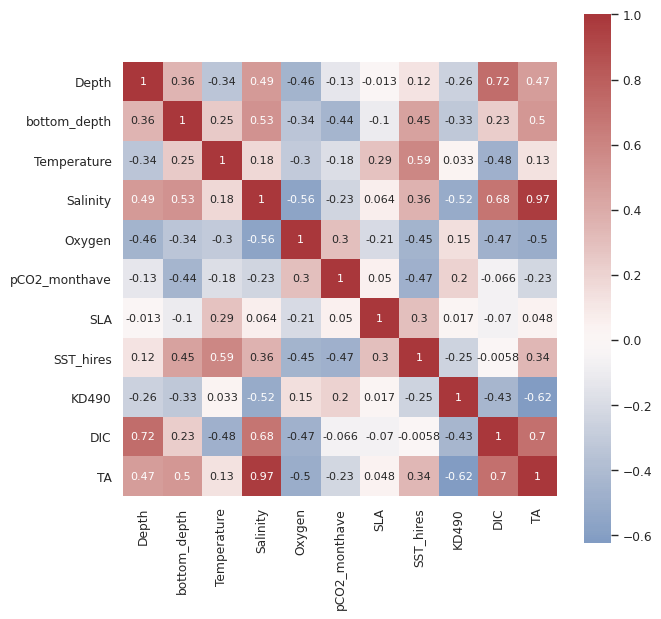

In [6]:
data = df[features + targets]
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.heatmap(corr_mat, ax=ax, cmap='vlag', center=0, square=True, annot=True, annot_kws={'fontsize':8})

## Neural Network regression 

Linear models and neural networks are very tied to the scale and distribution of each feature. Therefore, we rescale input features so they have mean=0 and std=1.

Using log-transformed Chl and KD490 does not change training, test and generalization scores significantly.

Best cross-validation score: 0.9571
Best parameters: {'mlpregressor__activation': 'logistic', 'mlpregressor__alpha': 0.0001, 'mlpregressor__hidden_layer_sizes': [200]}
Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', hidden_layer_sizes=[200],
                              random_state=42, solver='lbfgs'))])
Training set score: 0.9707
Test set score:     0.9524
Final model cross-validation mean score: 0.9000


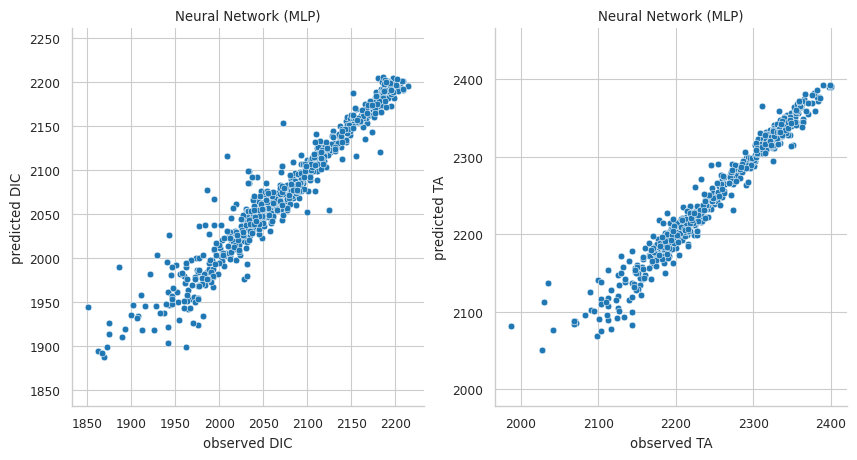

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(StandardScaler(), MLPRegressor(solver='lbfgs', random_state=42))

param_grid = {'mlpregressor__hidden_layer_sizes': [[100,], [200,], [300,], [400,]],
              'mlpregressor__activation' : ['logistic', 'tanh', 'relu'],
              'mlpregressor__alpha': [0.0001, 0.001, 0.01]}
gs_nnr = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gs_nnr.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_nnr.best_score_))
print('Best parameters: {}'.format(gs_nnr.best_params_))
print('Best estimator: {}'.format(gs_nnr.best_estimator_))

print('Training set score: {:.4f}'.format(gs_nnr.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_nnr.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_nnr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network (MLP)')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network (MLP)')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

#### Feature importance

A possible interpretation of the distribution of hidden node weights is that features that have small (absolute value) weights for all hidden nodes are less important to the model.

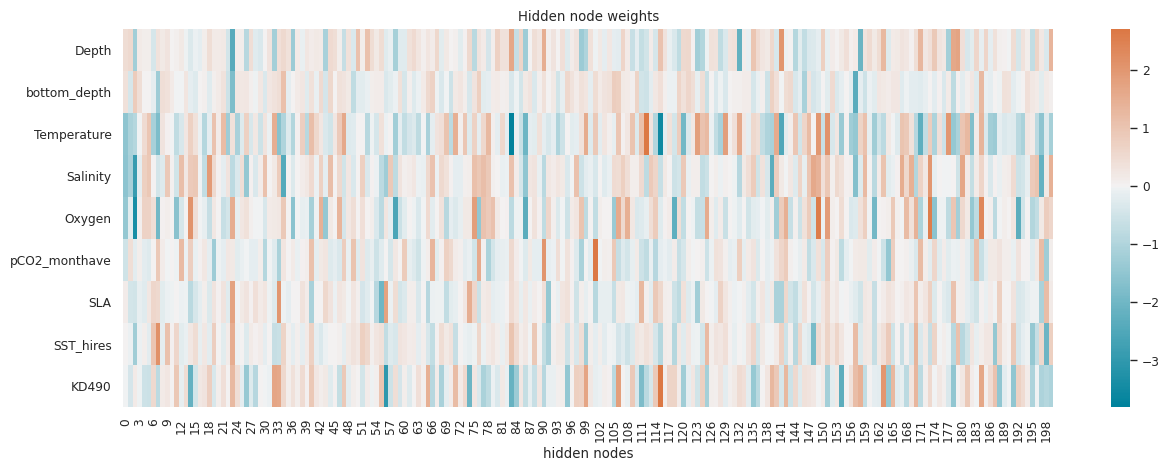

In [8]:
nn_weights = pd.DataFrame(gs_nnr.best_estimator_.named_steps['mlpregressor'].coefs_[0], index=features)
cmap = sns.diverging_palette(220, 20, s=100, as_cmap=True)
fig, ax = plt.subplots(figsize=(15, 5))
_ = sns.heatmap(nn_weights, center=0, cmap=cmap, ax=ax)
_ = ax.set(xlabel='hidden nodes', title='Hidden node weights')

#### Try adding interaction terms as input features

Adding interaction terms does not improve model test and generalization scores significantly.

In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, Y_train_poly, Y_test_poly = train_test_split(X_poly, Y, random_state=42)

scaler = StandardScaler().fit(X_train_poly)
X_train_poly_scaled = scaler.transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)
X_poly_scaled = scaler.transform(X_poly)

nnr = gs_nnr.best_estimator_.fit(X_train_poly_scaled, Y_train_poly)
print('Training score: {:.4f}'.format(nnr.score(X_train_poly_scaled, Y_train_poly)))
print('Test score:     {:.4f}'.format(nnr.score(X_test_poly_scaled, Y_test_poly)))
scores = cross_val_score(nnr, X_poly_scaled, Y, cv=5)
print('Cross-validation mean score: {:.4f}'.format(scores.mean()))

Training score: 0.9704
Test score:     0.9535
Cross-validation mean score: 0.9088


#### Try tunning paramaters with interaction terms as input features

Best cross-validation score: 0.9494
Best parameters: {'mlpregressor__activation': 'logistic', 'mlpregressor__alpha': 0.001, 'mlpregressor__hidden_layer_sizes': [200]}
Best estimator: Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', alpha=0.001,
                              hidden_layer_sizes=[200], random_state=42,
                              solver='lbfgs'))])
Training set score: 0.9708
Test set score:     0.9540
Final model cross-validation mean score: 0.9060


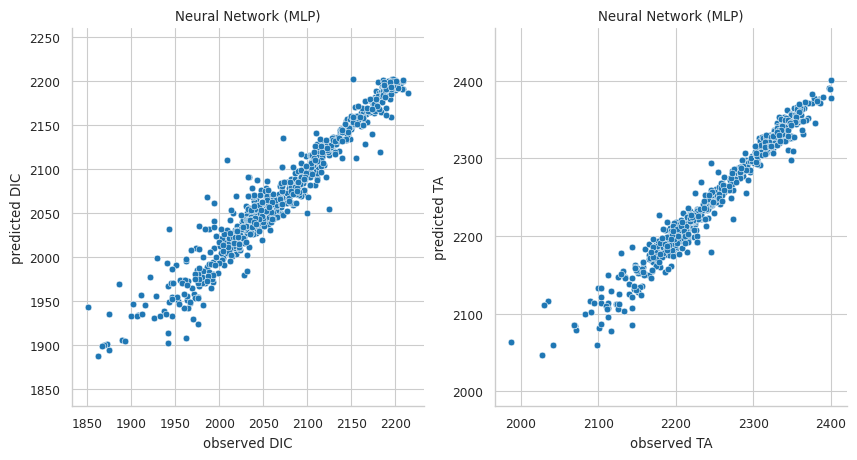

In [10]:
pipe2 = make_pipeline(PolynomialFeatures(interaction_only=True, include_bias=False), StandardScaler(), MLPRegressor(solver='lbfgs', random_state=42))

gs_nnr2 = GridSearchCV(pipe2, param_grid, cv=5, n_jobs=-1)
gs_nnr2.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_nnr2.best_score_))
print('Best parameters: {}'.format(gs_nnr2.best_params_))
print('Best estimator: {}'.format(gs_nnr2.best_estimator_))

print('Training set score: {:.4f}'.format(gs_nnr2.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_nnr2.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr2.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_nnr2.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network (MLP)')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network (MLP)')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

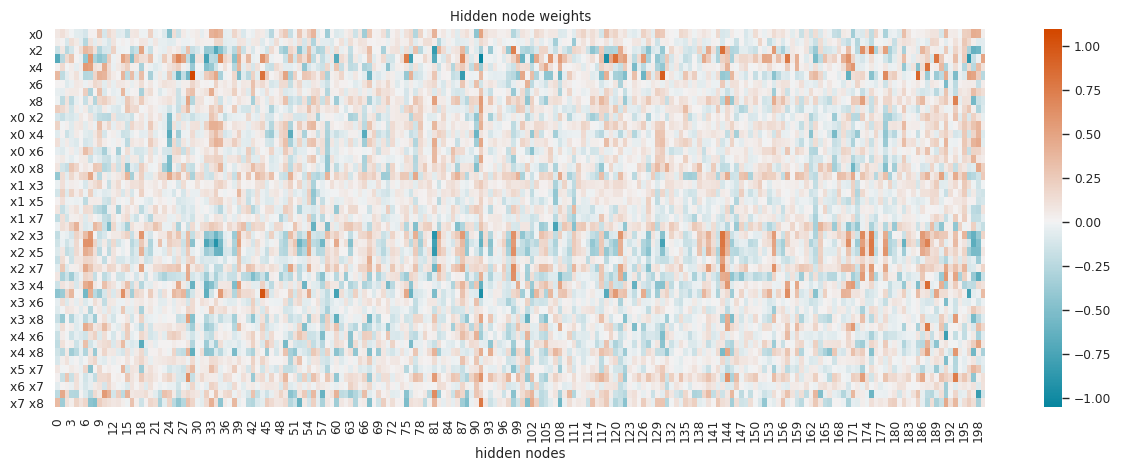

In [11]:
nn_weights = pd.DataFrame(gs_nnr2.best_estimator_.named_steps['mlpregressor'].coefs_[0], index=poly.get_feature_names())
# nn_weights = pd.DataFrame(nnr.coefs_[0], index=poly.get_feature_names())
cmap = sns.diverging_palette(220, 20, s=100, as_cmap=True)
fig, ax = plt.subplots(figsize=(15, 5))
_ = sns.heatmap(nn_weights, center=0, cmap=cmap, ax=ax)
_ = ax.set(xlabel='hidden nodes', title='Hidden node weights')

#### Try different geometries (number of layers and nodes per layer)

In [36]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

mlp = MLPRegressor(activation='relu', hidden_layer_sizes=[100,200,100], random_state=42, solver='lbfgs')
nnr2 = mlp.fit(X_train_scaled, Y_train)

print('Training score: {:.4f}'.format(nnr2.score(X_train_scaled, Y_train)))
print('Test score:     {:.4f}'.format(nnr2.score(X_test_scaled, Y_test)))
scores = cross_val_score(nnr2, X_scaled, Y, cv=5)
print('Cross-validation mean score: {:.4f}'.format(scores.mean()))

Training score: 0.9584
Test score:     0.9461
Cross-validation mean score: 0.8972


In [39]:
pipe = make_pipeline(StandardScaler(), MLPRegressor(random_state=42))
param_grid = {'mlpregressor__hidden_layer_sizes': [[100,100], [100,200,200], [200,200]],
              'mlpregressor__activation' : ['logistic', 'tanh', 'relu'],
              'mlpregressor__solver': ['lbfgs', 'adam']}
gs_nnr3 = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gs_nnr3.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_nnr3.best_score_))
print('Best parameters: {}'.format(gs_nnr3.best_params_))
print('Best estimator: {}'.format(gs_nnr3.best_estimator_))

print('Training set score: {:.4f}'.format(gs_nnr3.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_nnr3.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr3.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Best cross-validation score: 0.9530
Best parameters: {'mlpregressor__activation': 'relu', 'mlpregressor__hidden_layer_sizes': [100, 100], 'mlpregressor__solver': 'lbfgs'}
Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[100, 100], random_state=42,
                              solver='lbfgs'))])
Training set score: 0.9578
Test set score:     0.9482
Final model cross-validation mean score: 0.8776
